#### NOTEBOOK DE REPONSES #####
La version de python utilisé est la 3.7

In [1]:
# importation des differentes librairies
import pandas as pd
import numpy as np
%matplotlib inline

### 1- Statistiques descriptives

#### 1. Description du jeu de données:
<i>Presentation des analyses et des éventuels retraitements</i>.
<br> <i>Conclusion sur les variables pertinentes à selectionner</i>.

In [2]:
# lecture du dataset
filename = 'data_v1.0 .csv'
data = pd.read_csv(filename, index_col='index')
# Visualisation  des données
data.head()
#data['embauche'] = data['embauche'].apply(lambda x: 'Non' if x==0 else 'Oui')

,Unnamed: 0,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
index,,,,,,,,,,,,
0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 12 columns):
Unnamed: 0    20000 non-null int64
date          19909 non-null object
cheveux       19897 non-null object
age           19909 non-null float64
exp           19904 non-null float64
salaire       19905 non-null float64
sexe          19900 non-null object
diplome       19890 non-null object
specialite    19907 non-null object
note          19886 non-null float64
dispo         19894 non-null object
embauche      20000 non-null int64
dtypes: float64(4), int64(2), object(6)
memory usage: 2.0+ MB


In [4]:
# supression de la premiere colonne non informative
data = data.drop(data.columns[0], axis=1)

In [5]:
data.head()

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
index,,,,,,,,,,,
0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [6]:
# informations generale sur le dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 11 columns):
date          19909 non-null object
cheveux       19897 non-null object
age           19909 non-null float64
exp           19904 non-null float64
salaire       19905 non-null float64
sexe          19900 non-null object
diplome       19890 non-null object
specialite    19907 non-null object
note          19886 non-null float64
dispo         19894 non-null object
embauche      20000 non-null int64
dtypes: float64(4), int64(1), object(6)
memory usage: 1.8+ MB


In [7]:
print('valeurs manquantes par columnes:\n{}'.format(data.isnull().mean()*100))

valeurs manquantes par columnes:
date          0.455
cheveux       0.515
age           0.455
exp           0.480
salaire       0.475
sexe          0.500
diplome       0.550
specialite    0.465
note          0.570
dispo         0.530
embauche      0.000
dtype: float64


La plupart des variables explicatives contiennent des valeurs manquantes, toutes (<1%).
Plusieurs méthodes sont possibles. En effet, nous pouvons remplacer les valeurs manquantes par la moyenne, la médiane, enfin par regression des autres variables explicatives et enfin par le mode (pour les variables categorielles).


#### Regardons le nombre de lignes du dataset supprimés en cas de non conservation des valeurs manquantes

In [8]:
clean_data = data.dropna(how='any')
print('nombres de lignes manquantes: {}'.format(100-((len(clean_data)/len(data))*100)))

nombres de lignes manquantes: 4.89500000000001


In [9]:
clean_data = clean_data.drop(['date'], axis=1).reset_index()

Vu que le nombre de lignes à supprimer est lui inférieur sensiblement / <b>5%</b> de l'ensemble du dataset, on pourrait vraisemblablement les supprimer. Cependant, avant de considerer cette étape regardons l'impact d'une éventuel suppression sur le jeu de données.


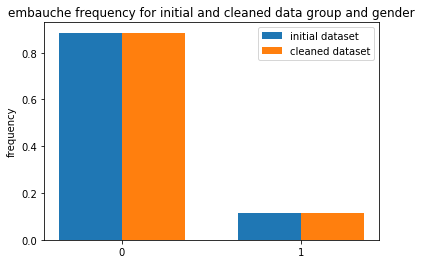

In [10]:
import matplotlib.pyplot as plt
labels = data['embauche'].value_counts().index
data_embauche_stat = data['embauche'].value_counts()
data_clean_embauche_stat = clean_data['embauche'].value_counts()
#normalize data
data_embauche_stat /= len(data['embauche'])
data_clean_embauche_stat /= len(clean_data['embauche'])

x = np.arange(len(labels))  # the label locations

width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data_embauche_stat, width, label='initial dataset')
rects2 = ax.bar(x + width/2, data_clean_embauche_stat, width, label='cleaned dataset')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('frequency')
ax.set_title('embauche frequency for initial and cleaned data group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

<br> 0 represente le cas <b> pas d'embauche.</b> 
<br> 1 represente le cas <b> embauche. </b>
<br> Le fait de supprimer l'ensemble des valeurs manquantes de notre jeu de données n'affecte pas 
la distribution de la variable à prédire i.e embauche. <br> Nous allons donc procéder à cette supression compte tenu aussi du faible nombre de valeurs manquantes (<5%).

#### Examinons la correlation lineaire entre les variables numériques du dataset

Il n'y a rien de significatif à tirer de cette analyse sauf le fait que les autres variables numériques sont faiblement reliés à la variable cible <b>embauche</b>.
<br> Meme la <i>note</i> obtenue à l'exercice de la recherche d'or est très peu correlé à la potentielle embauche.

#### Visualisation des variables numériques


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e46f18ba8>,
      dtype=object)

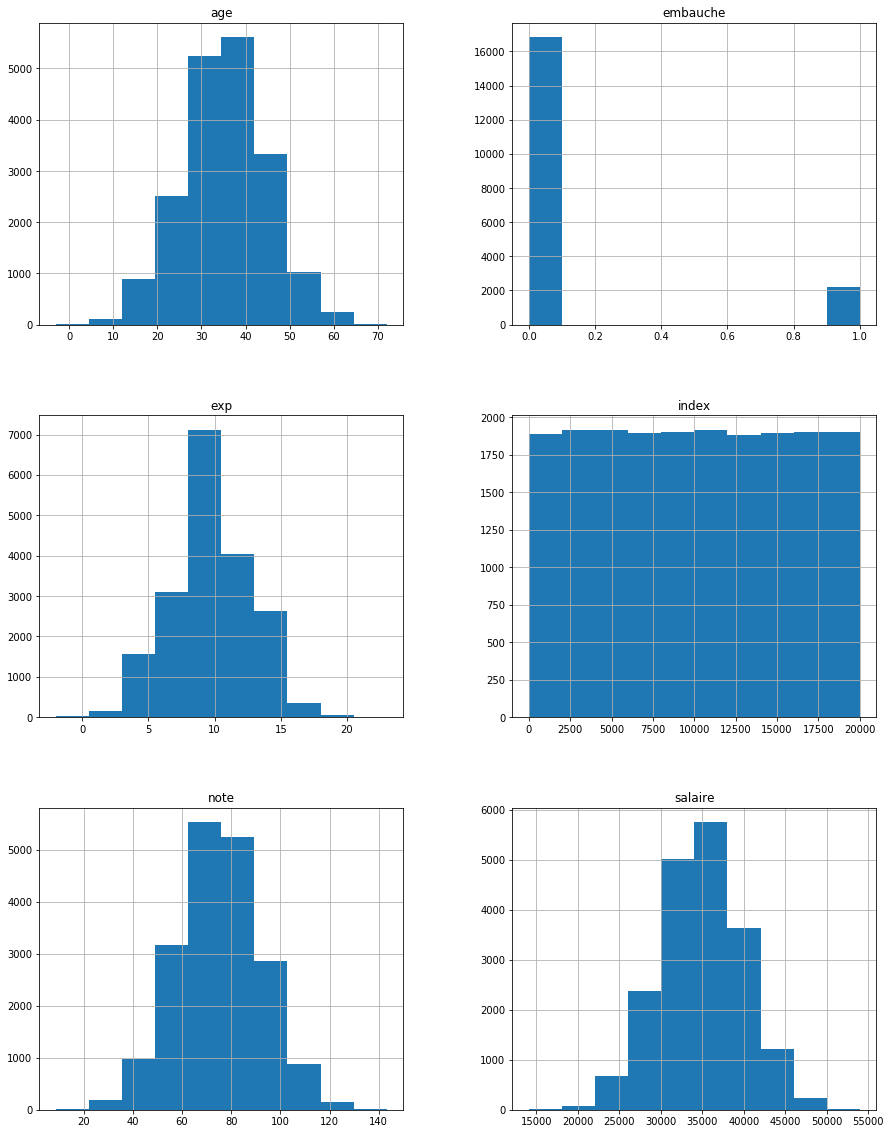

In [11]:
clean_data.hist(figsize=(15,20))

### 2. Analyse des possibles dependances statistiques

#### 2.1 Y'a t'il une dependance statistiquement significative entre la specialité et le sexe?
<b> La specialité</b> et le <b> sexe</b> sont tous deux des variables de type categorielle.
<br> Afin d'identifier un potentiel lien statistique entre les variables, nous allons procéder à un test d'hypothèse du <b>khi-deux</b>.

In [12]:
X = "specialite"
Y = "sexe"

tableau_contengence = clean_data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")


In [13]:
tableau_contengence

sexe,F,M,Total
specialite,,,
archeologie,1042.0,280.0,1322.0
detective,2409.0,1552.0,3961.0
forage,1899.0,2261.0,4160.0
geologie,2316.0,7262.0,9578.0
Total,7666.0,11355.0,19021.0


Calculons le tableau que l'on aurait du avoir en cas d'independance des deux evènements.

In [14]:
freq = tableau_contengence.loc['Total',:]/tableau_contengence.loc['Total','Total']

In [15]:
tableau_contengence_ind = tableau_contengence.copy()

In [16]:
tableau_contengence.loc['Total', 'Total']

for i in tableau_contengence.index:
    for j in tableau_contengence_ind.columns:
        if i!='Total' and j!='Total':
            tableau_contengence_ind.loc[i, j] = round((tableau_contengence_ind.loc['Total', j]/tableau_contengence_ind.loc['Total', 'Total'])*tableau_contengence_ind.loc[i, 'Total'], 1) 

In [17]:
tableau_contengence_ind

sexe,F,M,Total
specialite,,,
archeologie,532.8,789.2,1322.0
detective,1596.4,2364.6,3961.0
forage,1676.6,2483.4,4160.0
geologie,3860.2,5717.8,9578.0
Total,7666.0,11355.0,19021.0


In [18]:
carre_erreur_residuel_pondere = 0

for i in tableau_contengence_ind.index:
    for j in tableau_contengence_ind.columns:
        if i!='Total' and j!='Total':
            print(tableau_contengence.loc[i, j])
            print(tableau_contengence_ind.loc[i, j])
            diff = tableau_contengence.loc[i, j]-tableau_contengence_ind.loc[i, j]      
            print('1.diff {} \n'.format(diff))
            diff_carree = diff**2
            print('2.valeur ajoute {} \n'.format(diff_carree/tableau_contengence_ind.loc[i, j]))
            carre_erreur_residuel_pondere+= diff_carree/tableau_contengence_ind.loc[i, j]
            

1042.0
532.8
1.diff 509.20000000000005 

2.valeur ajoute 486.64534534534545 

280.0
789.2
1.diff -509.20000000000005 

2.valeur ajoute 328.54110491637107 

2409.0
1596.4
1.diff 812.5999999999999 

2.valeur ajoute 413.62989225757946 

1552.0
2364.6
1.diff -812.5999999999999 

2.valeur ajoute 279.2517804279793 

1899.0
1676.6
1.diff 222.4000000000001 

2.valeur ajoute 29.5012286770846 

2261.0
2483.4
1.diff -222.4000000000001 

2.valeur ajoute 19.916952565031824 

2316.0
3860.2
1.diff -1544.1999999999998 

2.valeur ajoute 617.7280037303766 

7262.0
5717.8
1.diff 1544.1999999999998 

2.valeur ajoute 417.0404071496029 



La distribution Chi-deux demande (tout comme l’analyse de variance) le calcul du degré de liberté, car cette distribution varie de forme en fonction du degré de liberté du tableau croisé. Cependant, le calcul du degré de liberté ne dépend pas du nombre de sujets, mais plutôt du nombre de rangées (Ligne) et de colonnes (Colonne) dans votre tableau croisé.

Degré de liberté = (nombre de rangées – 1) X (nombre de colonnes – 1) .e
<br> Degré de liberté = (4-1)*(2-1)= <b>3</b>

Dans ce cas-ci, le degré de liberté de la distribution Chi-deux est de 1. Il suffit maintenant d'aller comparer cette statistique Chi-deux à la table de distribution Chi-deux paramétrée par le degré de liberté en fonction du niveau de signification choisi (probabilité de se tromper) à 5% i.e <b>p = 0.05</b>. Il sera alors possible ou non de rejeter l'hypothèse nulle d'absence de relation.
<br> La règle est la suivante :
<br>• Si le khi-carré calculé est inférieur au khi-carré théorique : indépendance
<br>• Si le khi-carré calculé est supérieur au khi-carré théorique : dépendance
#### TABLE  
<img src='image_2.png'>


le khi-carre calculé (2592.25) est supérieur au khi théorique (7.81) dans notre cas.
ON peut donc vraisemblablement rejeté l'hypothèse nulle d'indépendance.
<br> Les deux variables sont donc statistiquement <b> dependantes </b>.
<br> Une implémentation de ce test est disponible sous <b> scipy </b> 
chi2_contingency

In [19]:
from scipy.stats import chi2_contingency
tableau_contengence = tableau_contengence.drop('Total', axis=1)
vtableau_contengence = tableau_contengence.drop('Total', axis=0)
chi2, pvalue, degrees, expected = chi2_contingency(tableau_contengence)
chi2, degrees, pvalue

(2592.2586573875888, 4, 0.0)

#### 2.2 Y'a t'il une dependance statistiquement significative entre la couleur des cheveux et le salaire demandé?
<b> La couleur des cheveux</b> est une variable categorielle et le <b> salaire</b> une variable numérique.
<br> Afin d'identifier un potentiel lien statistique entre les variables, nous allons procéder à un test <b> ANOVA (Analyse of Variance)</b> .

In [20]:
X = "cheveux" # qualitative
Y = "salaire" # quantitative


def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    # somme des carees totales
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    print('somme des carees totales {}'.format(SCT))
    # somme des carrees estimees
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    print('somme des carrees expliques {}'.format(SCE))
    return SCE/SCT
    
eta_squared(clean_data[X],clean_data[Y])

somme des carees totales 476491172405.1894
somme des carrees expliques 2065099532.8619144


0.004333972279985567

#### 2.3 Y'a t'il une dependance statistiquement significative entre le nombre d'années d'experiences et la note de l'exercice ?
<b> Le nombre d'années d'experiences</b> est une variable quantitative et la <b> note de l'exercice</b> une variable numérique.
<br> Afin d'identifier un potentiel lien statistique entre les variables, nous allons calculer <b>le coefficient de correlation de pearson </b> pour ces variables (car leurs distribution semblent gaussiennes).
<b> Dans le cas contraire, on aurait pu utilisé les coefficients de <b>spearman</b> ou de <b>kendall-tau</b> basés sur le rang.

L'ensemble des variables explicatives comme visualisées plus haut semblent suivre une distribution gaussienne. On peut donc calculer le coefficient de correlation de pearson entre ces deux variables

In [21]:
corr = clean_data.corr()
print('correlation entre la note et le reste des variables \n{}'.format(corr['note'].sort_values(ascending=False)))

correlation entre la note et le reste des variables 
note        1.000000
index       0.004936
embauche    0.003410
age        -0.004261
exp        -0.010883
salaire    -0.447937
Name: note, dtype: float64


On remarque que les variables etudiées ne sont pas linéairement correlés (coefficient de correlation de pearson de -0.01)

In [22]:
clean_data.isnull().mean()

index         0.0
cheveux       0.0
age           0.0
exp           0.0
salaire       0.0
sexe          0.0
diplome       0.0
specialite    0.0
note          0.0
dispo         0.0
embauche      0.0
dtype: float64

#### Variables à sélectionner

Il existe une dependance statistique forte entre le <b> sexe</b> et <b> la specialite</b>, on peut d

In [23]:
clean_data.isnull().mean()

index         0.0
cheveux       0.0
age           0.0
exp           0.0
salaire       0.0
sexe          0.0
diplome       0.0
specialite    0.0
note          0.0
dispo         0.0
embauche      0.0
dtype: float64

### 2. Machine learning

#### 2.1 Première approche arbre de décision


In [24]:
clean_data.head()


,index,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,4,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0
4,5,chatain,37.0,8.0,38558.0,M,master,geologie,63.46,non,1


In [25]:
clean_data.head()

,index,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,4,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0
4,5,chatain,37.0,8.0,38558.0,M,master,geologie,63.46,non,1


In [26]:
labels_to_keep = list(set(clean_data.select_dtypes(exclude=['number']))-set(['date', 'embauche']))
cat_features = clean_data[labels_to_keep]
num_features = clean_data.loc[:,['age', 'exp', 'salaire', 'note']]
labels = clean_data.loc[:, 'embauche']

In [27]:
num_features.head()

,age,exp,salaire,note
0,25.0,9.0,26803.0,97.08
1,35.0,13.0,38166.0,63.86
2,29.0,13.0,35207.0,78.50
3,35.0,6.0,28533.0,81.91
4,37.0,8.0,38558.0,63.46


In [28]:
cat_features.head()

,cheveux,sexe,diplome,specialite,dispo
0,roux,F,licence,geologie,non
1,blond,M,licence,forage,non
2,blond,M,licence,geologie,non
3,roux,F,licence,detective,non
4,chatain,M,master,geologie,non


In [29]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, silhouette_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn import svm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
plt.style.use('ggplot')


In [30]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """select column(s) of the dataframe"""

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, attribute_names):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        X = pd.get_dummies((X[self.attribute_names]))
        return X
    

In [31]:
def dummies_categorical_var(dataframe):
    """
    create dummies variables from categorical
    INPUT
    -single_label_list: column with unique label per row
    -multi_label_list : column with multiple label per row
    -dataframe: dataframe with all this columns
    OUTPUT
    -return a dataframe with dummies variables
    """
    # mettre en place les controles

    # mettre en place des pipelines de donnees en s'appuyant sur le typage
    # canard du Pipeline de sklearn
    single_label_list = dataframe.columns
    
    pipeline_mono = Pipeline(
        [("one_hot_encoding", DataFrameSelector(single_label_list))]
    )



    # convertir les variables en valeurs numeriques
    data_with_dummies = pipeline_mono.fit_transform(dataframe)


    return data_with_dummies




In [33]:
from sklearn.model_selection import train_test_split
cat_dummies = dummies_categorical_var(cat_features)
features = pd.concat([cat_dummies,num_features], axis=1)
from sklearn.preprocessing import MinMaxScaler

pre_processer = MinMaxScaler()
#features_trans = pre_processer.fit_transform(features)
#features = pd.DataFrame(features_trans, columns= features.columns)

# on va ici diviser le dataframe en 80% pour l'apprentissage et 20% pour le test
split = StratifiedShuffleSplit(n_splits=1, random_state=42)
for train_index, test_index in split.split(clean_data, clean_data['embauche']):
    train_set = features.loc[train_index, :]
    train_label = labels[train_index]
    test_set = features.loc[test_index, :]
    test_label = labels[test_index]
    

In [35]:
pd.DataFrame(train_set).isnull().mean()

cheveux_blond             0.0
cheveux_brun              0.0
cheveux_chatain           0.0
cheveux_roux              0.0
sexe_F                    0.0
sexe_M                    0.0
diplome_bac               0.0
diplome_doctorat          0.0
diplome_licence           0.0
diplome_master            0.0
specialite_archeologie    0.0
specialite_detective      0.0
specialite_forage         0.0
specialite_geologie       0.0
dispo_non                 0.0
dispo_oui                 0.0
age                       0.0
exp                       0.0
salaire                   0.0
note                      0.0
dtype: float64

In [37]:
from sklearn.metrics import f1_score, accuracy_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

def tree_param_selection(data_set, label_set, nfolds):
    """predire les metiers manquants
    Parametres
    ----------
    data_set : jeu de donnees ne contenant que les metiers manquants
    label_set : modele de prediction charge d'effectuer la prediction
    nfolds : nombre de groupe pour la cross validation
    Returns
    -------
    best_estimator : meilleur estimateur
    """
    
    # Number of trees in random forest
    n_estimators = [100, 200, 500]
    # Number of features to consider at every split
    max_features = ["auto", "log2", "sqrt", None]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    param_grid = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "bootstrap": bootstrap,
    }
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=param_grid,
        scoring=f1,
        cv=nfolds,
        verbose=2,
        n_jobs=-1,
    )
    grid_search.fit(data_set, label_set)
    best_estimator = grid_search.best_estimator_
    return best_estimator

n_folds = 4
tree_clf = tree_param_selection(train_set, train_label, n_folds)
# prediction on test_set
prediction_test_set = tree_clf.predict(test_set)
print(
    "f1 score : {}% \n".format(
        f1_score(test_label, prediction_test_set) * 100
    )
)

# calculer la matrice de confusion
confusion_matrice = confusion_matrix(
    test_label, prediction_test_set, labels=list(np
                                               .unique(test_label))
)
print('columnes matrice confusion {}'.format(list(np.unique(test_label))))
print("matrice de confusion \n {} ".format(confusion_matrice))

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
/home/cursedomonstro/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.7min finished


f1 score : 60.50420168067227% 

columnes matrice confusion [0, 1]
matrice de confusion 
 [[1654   31]
 [ 110  108]] 


In [ ]:
def svc_param_selection(data_set, label_set, nfolds):
    """predire les metiers manquants
    Parametres
    ----------
    data_set : jeu de donnees ne contenant que les metiers manquants
    label_set : modele de prediction charge d'effectuer la prediction
    nfolds : nombre de groupe pour la cross validation
    Returns
    -------
    best_estimator : meilleur estimateur
    """
    Cs = [10, 0.1, 1]
    gammas = [0.01, 0.1, 1, 10]
    kernel = ["rbf", "sigmoid", "linear"]
    param_grid = {"C": Cs, "gamma": gammas, "kernel": kernel}
    grid_search = GridSearchCV(
        estimator=svm.SVC(),
        param_grid=param_grid,
        cv=nfolds,
        scoring=f1,
        verbose=2,
        n_jobs=-1,
    )
    grid_search.fit(data_set, label_set)
    best_estimator = grid_search.best_estimator_
    return best_estimator


modele_svm = svc_param_selection(train_set, train_label, n_folds)
# prediction on test_set
prediction_test_set = modele_svm.predict(test_set)
print(
    "accuracy on test set : {}% \n".format(
        f1_score(test_label, prediction_test_set)
    )
)
# calculer la matrice de confusion
confusion_matrice = confusion_matrix(
    test_label, prediction_test_set, labels=list(np.unique(test_label))
)
print('columnes matrice confusion {}'.format(list(np.unique(test_label))))
print("matrice de confusion \n {} ".format(confusion_matrice))

In [ ]:
data['embauche'].value_counts()/len(data)